In [1]:
import numpy as np
import matplotlib.pyplot as plt; plt.ion()

from scipy.io import mmread
from sklearn.decomposition import PCA
from umap import UMAP
from hdbscan import HDBSCAN

A helper function to visualize the distribution of dataset values at the various stages of preprocessing:

In [2]:
def summarize(X):
    print("Dimensions: ", X.shape)

    # compute some simple metrics to get a feel for the distribution of values
    print("Min    : ", np.min(X))
    print("Mean   : ", np.mean(X))
    print("Median : ", np.median(X))
    print("99.9%  : ", np.percentile(X.ravel(), 99.9))
    print("Max    : ", np.max(X))

    # plot distribution
    fig, ax = plt.subplots(1,1)
    ax.hist(X.ravel(), bins=100)
    ax.set_xlabel('Counts')
    ax.set_ylabel('Frequency')
    plt.show()

# Load the data:

Dimensions:  (9128, 27998)
Min    :  0
Mean   :  0.2623772026347944
Median :  0.0
99.9%  :  27.0
Max    :  6916


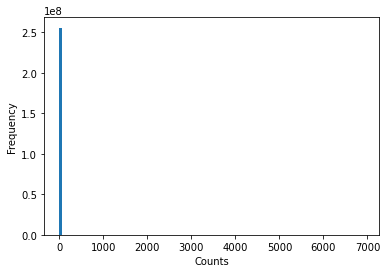

In [3]:
file_path='/ifs/obds-training/jan21/shared/python/filtered_gene_bc_matrices/mm10/matrix.mtx'
X = mmread(file_path)
X = np.array(X.todense().transpose())
summarize(X)
#This is some 10X single cell data. It has been mapped etc, this is the counts table.
#column = gene, row = cell

# Preprocess the data (a.k.a quality control)
- aim to remove any samples with 0 counts --> turns out that someone has already done this
- first step sum the counts over all the samples

Dimensions:  (9128,)
Min    :  2223
Mean   :  7346.036919368975
Median :  6360.5
99.9%  :  37470.50300000044
Max    :  58312


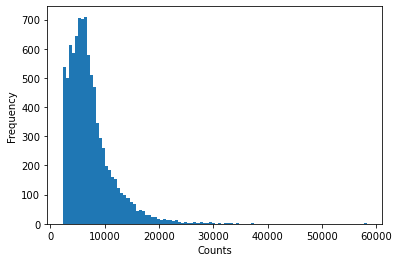

In [5]:
total_reads_per_sample = np.sum(X, axis=1)
summarize(total_reads_per_sample) #Using summarize will show data info and draw a graph

- So rather we want to cut off the upper end for the counts > 20000 (maybe caused by doublets etc)
- We are not adding on a column that we later need to remove. We are just making a new list that has the same length as the array, and then we are telling the array to look for instances where they are <20000.

Dimensions:  (8965,)
Min    :  2223
Mean   :  7010.351031790296
Median :  6296.0
99.9%  :  19562.684000000037
Max    :  19963


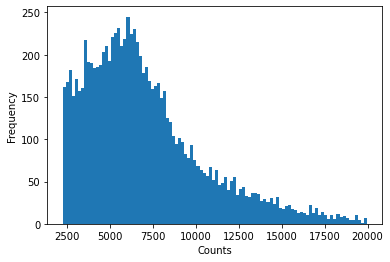

In [22]:
filtered_samples = X[total_reads_per_sample < 20000]
new_total_reads_per_sample = np.sum(filtered_samples, axis = 1)
summarize(new_total_reads_per_sample)


So we have removed samples that are too dense. 
Next step is to remove any columns that are empty (genes that are not expressed).



Dimensions:  (27998,)
Min    :  0
Mean   :  2244.7245160368598
Median :  28.0
99.9%  :  193466.19200000027
Max    :  916304


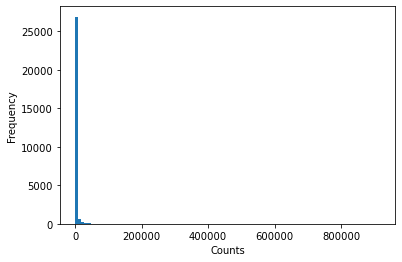

In [13]:
total_reads_per_gene = np.sum(filtered_samples, axis = 0) 
#Use the previously filtered data and set the opposite axis so we are summing columns not rows
summarize(total_reads_per_gene)

Now we want to cut off any genes where expression is zero

Dimensions:  (19072,)
Min    :  1
Mean   :  3295.2913695469797
Median :  414.5
99.9%  :  221315.73800002504
Max    :  916304


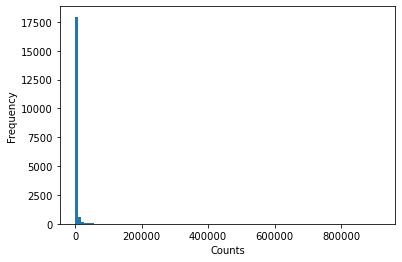

In [15]:
expressed_genes = filtered_samples[:,total_reads_per_gene > 0] #colon means use all rows
new_total_reads_per_gene = np.sum(expressed_genes, axis = 0)
summarize(new_total_reads_per_gene)

It might be more meaningful to remove genes that are only expressed in >0 cells  
So we need to know for each row, how many non-zero entries are there?  
This is going to require a true/false argument.
expressed_genes > 0 generates a true/false matrix  
Then when we sum, true=1 and we are collecting all rows where the sum is over 0.

Dimensions:  (19072,)
Min    :  0.00011154489682097045
Mean   :  0.13315824122145403
Median :  0.04071388733965421
99.9%  :  0.996868823201339
Max    :  0.9995538204127161


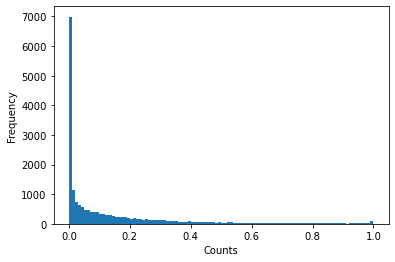

In [18]:
samples_per_gene = np.mean(expressed_genes > 0, axis = 0) 
summarize(samples_per_gene)

Now we are going to look at the expression level and see if it comes from a high level in one sample (throw out) or lower number of reads in multiple samples (keep).  
So next we are going to exclude all genes that are not expressed in 5% of our samples.  
So we need to convert samples_per_gene to a % by dividing by total number of samples.
So for this we have updated sum to mean in box 17 row 1.

Dimensions:  (8997,)
Min    :  0.05008365867261573
Mean   :  0.2713632436566666
Median :  0.1894032348020078
99.9%  :  0.9975464584495259
Max    :  0.9995538204127161


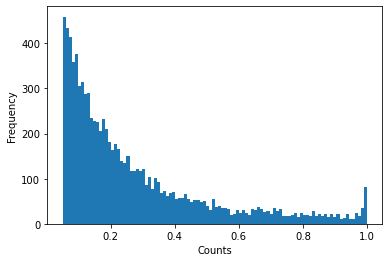

In [24]:
enough_samples = samples_per_gene > 0.05
new_filtered_genes = expressed_genes[:, enough_samples]
new_samples_per_gene = np.mean(new_filtered_genes > 0, axis = 0)
summarize(new_samples_per_gene)

Now make sure we are selecting all genes that are expressed above a certain level

Dimensions:  (8965,)
Min    :  108
Mean   :  2441.4551031790297
Median :  2415.0
99.9%  :  4673.4320000000225
Max    :  4966


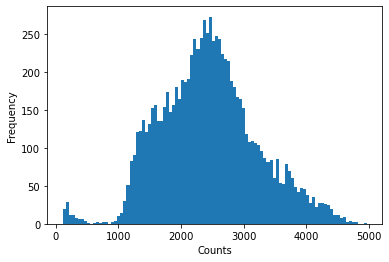

In [25]:
total_genes_expressed_per_sample = np.sum(new_filtered_genes > 0, axis =1)
#This makes a selection of True/False as to whether the gene is expressed
summarize(total_genes_expressed_per_sample) #in this figure, counts represents the number of expressed genes per cell

Dimensions:  (8850,)
Min    :  1003
Mean   :  2468.6833898305085
Median :  2425.0
99.9%  :  4674.81200000002
Max    :  4966


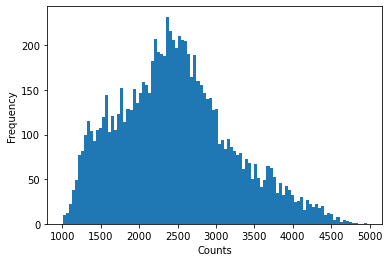

In [30]:
#Remove cells were <1000 genes are expressed
cleaned = new_filtered_genes[total_genes_expressed_per_sample > 1000]
#check how this looks on the graph
new_total_genes_expressed_per_sample = np.sum(cleaned >0, axis = 1)
summarize(new_total_genes_expressed_per_sample)

# Transform the data to make it more normally distributed

- log transform the data
- the log of 0 is negative infinity so we need to first add 1 to our data, then the log of 1 is 0 (as we did yesterday)

Dimensions:  (8850, 8997)
Min    :  0
Mean   :  0.7679545535894262
Median :  0.0
99.9%  :  45.0
Max    :  4665


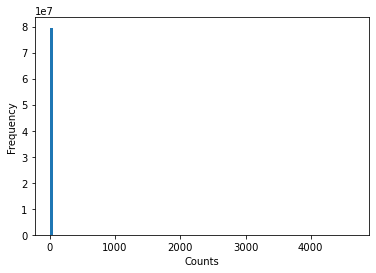

In [32]:
summarize(cleaned)#shows us that the data is all still really near to 0

Dimensions:  (8850, 8997)
Min    :  0.0
Mean   :  0.2851408507330191
Median :  0.0
99.9%  :  3.828641396489095
Max    :  8.448057452581375


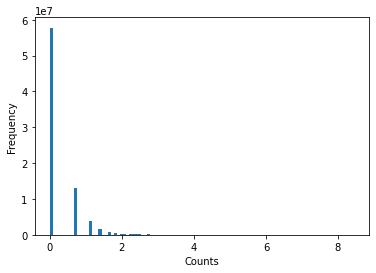

In [31]:
log_transformed = np.log(cleaned +1) #sometimes log1p function is more accurate
summarize(log_transformed)

Dimensions:  (8850, 8997)
Min    :  0.0
Mean   :  0.279360617991232
Median :  0.0
99.9%  :  2.5649493574615367
Max    :  2.5649493574615367


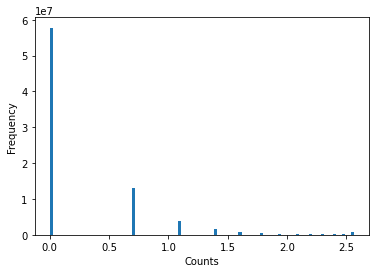

In [34]:
#truncate large values (there are very few counts that are large, they are real read counts but they are outliers)
#We will use the 99th percentile
cutoff = np.percentile(log_transformed, 99)
truncated = log_transformed.copy() #this copies log_transformed to a different variable
truncated[truncated > cutoff] = cutoff #then we can do the cut off in place so we are not changing the original data
#could also use truncated = np.clip(log_transformed, 0, cutoff)
#which says take log_transformed from 0 to cutoff
summarize(truncated)

Dimensions:  (8850, 8997)
Min    :  -29.207258201638812
Mean   :  3.33739794975569e-15
Median :  -0.3390229894125059
99.9%  :  5.222246756575118
Max    :  13.406282107728671


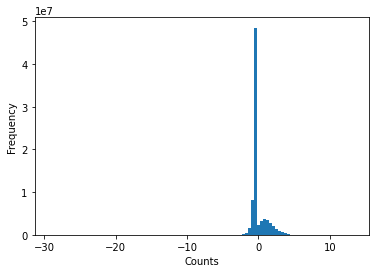

In [36]:
#convert to z-scores in order to bring your data into a pre-defined range
#compute the mean and sd
#set the mean to zero divide by the sd
#so the sd of the new distribution is 1
mean = truncated.mean(axis=0)
std = truncated.std(axis=0)
normalized = (truncated - mean)/std
summarize(normalized)


# Dimensionality reduction using PCA

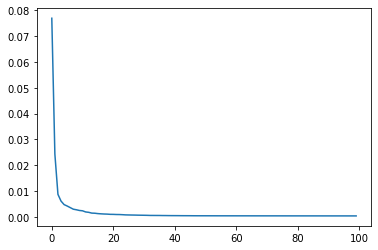

In [38]:
#set the number of components in the PC (otherwise it will default to the number of dimensions in our data)
pca_instance = PCA(n_components = 100)
pca_instance.fit(normalized)
plt.plot(pca_instance.explained_variance_ratio_) #this will help us determine how many components we actually want to use
#The graph shows that >20 components brings diminishing returns

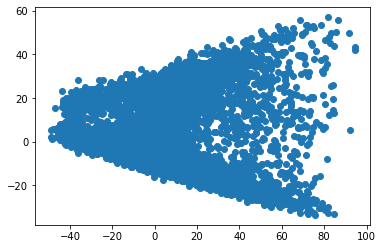

In [39]:
pca_instance = PCA(n_components = 20)
pca_instance.fit(normalized)
pca_transformed = pca_instance.transform(normalized) #gives us a new array that is re-mapped, you are transforming the data
#you could push other datasets through the transform you have generated for this dataset
#for example if you have ipSC differentiated into neurons, you could first do a PCA on real neuron data and then push through the iPSC data
#plot first 2 components as a scatter plot
#: means all rows, then first column (or second column)
plt.plot(pca_transformed[:,0],pca_transformed[:,1], "o")
#x is the first column PC1, y is the second column PC2
#each dot represents one sample

# Dimensionality reduction using UMAP

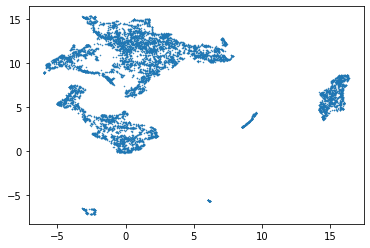

In [62]:
#now we will reduce to 2 dimensions using umap
umap_instance = UMAP(n_components = 2, n_neighbors = 10, min_dist = 0.05)
#do the transform and the fit in one go (because otherwise the maths won't work)
umap_transformed = umap_instance.fit_transform(pca_transformed)
#plot first vs second component
#markersize changes the size of the dots
plt.plot(umap_transformed[:,0], umap_transformed[:,1], "o", markersize = 0.5)

The different cell types are in the different blobs on the graph  
Useful tutorial on interpretation of these kind of plots: https://distill.pub/2016/misread-tsne/
Lots of small spread out clusters is a bad sign.   
You want one big cluster which is evenly distributed more or less.  
You can alter the umap parameters e.g. with n_neighbours, min_dist.   
This can affect the interpretation e.g. how many cell types are present.  
The UMAP documentation is helpful, if you are using umap you should definitely read this! https://umap-learn.readthedocs.io/en/latest/  


# Clustering using HDBSCAN

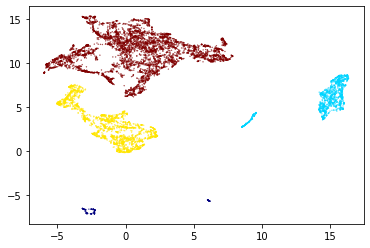

In [65]:
hdbscan_instance = HDBSCAN(min_samples = 50, min_cluster_size = 500)
#fit the model and predict the cluster labels
labels = hdbscan_instance.fit_predict(umap_transformed)
labels.size
plt.scatter(umap_transformed[:,0], umap_transformed[:,1], c = labels.astype(np.int), cmap="jet", s = 0.1)
#c is label colour
#s is point size
#vary the parameters i.e. cluster size and min_samples and see what happens

So here the interpretation is that the big red blob is neurons, and the others might be things like astrocytes and vascular cells